https://www.kaggle.com/keremt/pytorch-entity-embeddings was super helpful with this.

In [10]:
import gc
import os
import random
from pathlib import Path
from typing import Union, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim import SGD

import numpy as np
import pandas as pd
import skopt

import matplotlib.pyplot as plt
%matplotlib inline

Seed random number generators for reproducibility.

In [11]:
random_seed = 42

def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(random_seed)

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [50]:
def preprocess(data: pd.DataFrame, cats: List[str]) -> pd.DataFrame:
    data.fillna('missing', inplace=True)
    for c in cats:
        data[c] = data[c].astype('category').cat.codes
    return data

def EimDataPreprocess(data, cats, inplace=True):
    ### Each categorical column should have indices as values 
    ### Which will be looked up at embedding matrix and used in modeling
    ### Make changes inplace
    if inplace:
        for c in cats:
            data[c].replace({val:i  for i, val in enumerate(data[c].unique())}, inplace=True)
        return data
    else:
        data_copy = data.copy()
        for c in cats:
            data_copy[c].replace({val:i  for i, val in enumerate(data_copy[c].unique())}, inplace=True)
        return data_copy
        
def get_embs_dims(data, cats, minimum=2):
    cat_sz = [len(data[c].unique()) for c in cats]
    return [(c, max(min(50, (c+1)//2 + 1), minimum)) for c in cat_sz]
    
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

# Data processing

In [51]:
eim_csv = Path('..', '..', 'fastai', 'data', 'good_reaction_trials_categorified.csv')
eim_df = pd.read_csv(eim_csv)
eim_df.head()

,_id,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
0,5410f69308ad6ee3090e387a,dublin,female,0,other,0,0,0,41.0,False,...,1,0,0,0,0,0,0,0,0,0
1,5410f69508ad6ee3090e3892,dublin,male,0,irish,0,0,0,41.0,False,...,0,0,0,0,0,1,0,0,1,1
2,5410f6d008ad6ee3090e3994,dublin,male,0,other,0,0,0,25.0,False,...,0,0,0,0,0,1,0,1,1,0
3,5410f6d008ad6ee3090e3998,dublin,female,0,irish,0,0,0,21.0,True,...,0,0,0,0,0,1,0,0,1,1
4,5410f6d008ad6ee3090e399c,dublin,male,0,irish,0,0,0,20.0,False,...,1,0,0,0,0,1,0,0,1,1


In [52]:
cats = ['location', 'sex', 'musical_background', 'nationality', 'visual_impairments', 'hearing_impairments', 
        'musicpref_traditional_irish', 'musicpref_jazz', 'musicpref_folk', 'musicpref_hiphop', 'musicpref_classical', 
        'musicpref_none', 'musicpref_rock', 'musicpref_hip_hop', 'musicpref_world', 'musicpref_pop', 'musicpref_dance',
        'language']

conts = ['musical_expertise', 'age', 'control_activity', 'control_tension', 'control_engagement', 
         'control_positivity', 'control_like_dislike', 'song_chillsshiversthrills', 'song_activity', 'song_tension', 
         'song_familiarity', 'song_engagement', 'song_positivity', 'song_like_dislike', 'song_inspired', 'song_wonder', 
         'song_spirituality', 'song_thrills', 'song_chills', 'song_tenderness', 'song_nostalgia', 'song_goosebumps', 
         'song_overwhelmed', 'song_shivers', 'control_power', 'song_transcendence', 'song_sadness', 'song_joyfulactivation', 
         'song_peacefulness', 'song_power', 'personality_trusting', 'personality_artistic', 'personality_imagination', 
         'personality_reserved', 'personality_outgoing', 'personality_lazy', 'personality_stress', 'personality_nervous', 
         'personality_fault', 'personality_thorough', 'concentration']

In [53]:
# Remove id, name, and item_description columns
eim_df = eim_df.drop(['_id'], axis=1)

In [54]:
eim_df.loc[eim_df.critical_reaction == False, 'critical_reaction'] = 0
eim_df.loc[eim_df.critical_reaction == True, 'critical_reaction'] = 1

In [55]:
# Replace missing values and convert cats columns to categories
eim_df = preprocess(eim_df, cats)

In [56]:
eim_df = eim_df.reset_index(drop=True)

In [57]:
# Convert values in categorical columns to 0, 1, 2, 3, ... from the top of the DataFrame down
eim_df = EimDataPreprocess(eim_df, cats, inplace=True)

In [58]:
# Split combined DataFrame back out into train and test DataFrames
# train_df = train_test_df.iloc[range(len(train_df))]
# test_df = train_test_df.iloc[range(len(train_df),len(train_test_df))]

In [59]:
train_pct, valid_pct, test_pct = .7, .15, .15
idxs = eim_df.index.values
np.random.shuffle(idxs)
train_valid_split = int(np.floor(train_pct * len(eim_df)))
valid_test_split = int(np.floor((train_pct + valid_pct) * len(eim_df)))
train_idxs, valid_idxs, test_idxs = idxs[:train_valid_split], idxs[train_valid_split:valid_test_split], idxs[valid_test_split:]

In [60]:
eim_df.head()

,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,control_activity,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
0,0,0,0,0,0,0,0,41.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,41.0,0,0,...,1,0,0,0,0,1,0,0,1,1
2,0,1,0,0,0,0,0,25.0,0,0,...,1,0,0,0,0,1,0,1,1,0
3,0,0,0,1,0,0,0,21.0,1,0,...,1,0,0,0,0,1,0,0,1,1
4,0,1,0,1,0,0,0,20.0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [61]:
# train_valid_df = train_df.copy()
train_df = eim_df.iloc[train_idxs, :]
valid_df = eim_df.iloc[valid_idxs, :]
test_df = eim_df.iloc[test_idxs, :]

In [62]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [63]:
train_df.head()

,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,control_activity,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
0,0,1,0,0,0,0,0,21.0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,2,1,0,3,0,4,0,12.0,0,4,...,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,31.0,0,0,...,0,0,0,0,0,1,1,1,1,0
3,0,0,1,1,0,3,0,14.0,0,0,...,1,0,0,0,0,0,1,0,1,1
4,0,1,0,1,0,0,1,12.0,0,0,...,1,0,0,0,0,0,0,0,1,0


1.552593131223876

In [70]:
def std_median(df, conts):
    return df[conts].std().median()

In [138]:
dummy_df = pd.DataFrame({'foo': [1, 2, 1], 'bar': [2, 6, 7], 'baz': [1, 1, 1], 'bat': [1, 0, 0], 'qux': [0, 1, 0]})
dummy_df

,foo,bar,baz,bat,qux
0,1,2,1,1,0
1,2,6,1,0,1
2,1,7,1,0,0


In [139]:
dist_mat = np.zeros((len(dummy_df), len(dummy_df)))

In [144]:
dummy_stds = std_median(dummy_df, dummy_conts)
dummy_stds

1.6115507901271082

In [145]:
for i in range(len(dummy_df)):
    a = dummy_df.iloc[i]
    
    for j in range(len(dummy_df)):
        b = dummy_df.iloc[j]
        dist = nc_distance(a, b, dummy_cats, dummy_conts, dummy_stds)
        dist_mat[i][j] = dist

In [151]:
dist_mat[1]

array([4.49701029, 0.        , 2.28541059])

In [154]:
np.argsort(dist_mat[1])

array([1, 2, 0])

In [156]:
np.argsort(dist_mat[1])[::-1]

array([0, 2, 1])

In [120]:
def nc_distance(a, b, cats, conts, std_med):
    a_cats = a[cats]
    a_conts = a[conts]
    b_cats = b[cats]
    b_conts = b[conts]
    
    cont_diff = a_conts - b_conts
    cont_distance = np.dot(cont_diff, cont_diff)
    
    cat_diff = np.sum(a_conts != b_conts)
    
    return np.sqrt(cont_distance + cat_diff * std_med)

In [21]:
# Segment train and test DataFrames into input and output DataFrames
train_input, train_y = train_df.drop('critical_reaction', 1), train_df.critical_reaction
valid_input, valid_y = valid_df.drop('critical_reaction', 1), valid_df.critical_reaction
test_input, test_y = test_df.drop('critical_reaction', 1), test_df.critical_reaction

In [22]:
# Determine the range of output values
y_range = (train_y.min(), train_y.max())
y_range

(0, 1)

In [23]:
# Get a list of tuples of embedding dimensions
# Tuples are (category_size, embedding_size), where embedding_size is the smaller of 50 and half the number of unique values in that category
emb_szs = get_embs_dims(eim_df, cats)
emb_szs

[(7, 5),
 (2, 2),
 (2, 2),
 (16, 9),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (4, 3)]

In [24]:
# Delete temporary DataFrames to free up memory
del eim_df
gc.collect()

25

# Model construction

In [25]:
# EmbeddingModelData exposes path, trn_dl, val_dl, and test_dl as attributes on the object. On creation, it:
# - Takes the train_input, train_y, and cats and creates an EmbeddingDataset
# - Takes the test_input, test_y, and cats and creates an EmbeddingDataset
# - Wraps these EmbeddingDatasets in DataLoaders, passing on bs to the DataLoader
# - Stories these DataLoaders and path as attributes on the created object

# EmbeddingDataset:
# - Used here, the entire input DataFrame, a list of categories, and an output DataFrame are provided
# - The input DataFrame is split into a categorical and a continuous DataFrame
# - The 'cats' DataFrame is converted to an int64 NumPy ndarray and stored on the EmbeddingDataset object as the cats attribute
# - The 'conts' DataFrame is converted to a float32 NumPy ndarray and stored on the EmbeddingDataset object as the conts attribute
# - The 'y' DataFrame is converted to a float32 NumPy array and stored on the EmbeddingDataset object as the y attribute
# - If no cats are provided, the cats attribute is an array of zeros the length of the conts list, this is similar for conts
# - When asked for an item, returns: [cats, conts, y] for that particular item

model_data = EimModelData.from_data_frames('./tmp', train_input, valid_input, train_y, valid_y, 
                                           cats, conts, bs=len(train_input), test_df=test_df)
emb_model = EimModel(emb_szs, len(conts), 0.04, 1, [1000, 500], 0.01, y_range=y_range, classify=True, use_bn=False)
emb_model.to(device)
print(emb_model)

EimModel(
  (embs): ModuleList(
    (0): Embedding(7, 5)
    (1): Embedding(2, 2)
    (2): Embedding(2, 2)
    (3): Embedding(16, 9)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
    (10): Embedding(2, 2)
    (11): Embedding(2, 2)
    (12): Embedding(2, 2)
    (13): Embedding(2, 2)
    (14): Embedding(2, 2)
    (15): Embedding(2, 2)
    (16): Embedding(2, 2)
    (17): Embedding(4, 3)
  )
  (lins): ModuleList(
    (0): Linear(in_features=88, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.01)
    (1): 

# Training loop definition

In [26]:
from torch import Tensor
from IPython.display import clear_output, display

# Validation
def eim_validate(model, model_data, criterion, epochs):
    model.eval()
    running_loss = []
    for data in iter(model_data.val_dl):
        # get inputs
        x_cats, x_conts, y = data

        # wrap with variable
        x_cats = torch.LongTensor(x_cats).to(device)
        x_conts = torch.FloatTensor(x_conts).to(device)
        y = torch.FloatTensor(y).to(device)
        x_cats.requires_grad = False
        x_conts.requires_grad = False
        y.requires_grad = False
        
        outputs = model(x_cats, x_conts)
        loss = criterion(outputs, y)
        running_loss.append(loss.cpu().detach().data)    
    return np.mean(running_loss)
    

# Training:
# - Gets next batch from DataLoader
# - Breaks batch into cats, conts, and output
# - Converts these into tensors
# - Specifies that gradients for cats and conts should not be computed
# - Performs forward/backward pass

def eim_train(model, model_data, optimizer, criterion, epochs, patience=50, print_output=True, save_best=False, save_path=Path('.', 'best_model.pkl')):
    model.train()
    
    running_losses = {'train': [], 'validation': []}
    
    best_loss = float('inf')
    es_patience = patience
    es_counter = 0
    
    epoch_counter = 0
    for epoch in range(epochs):
        epoch_counter += 1
        
        for data in iter(model_data.trn_dl):            
            
            # Get inputs
            x_cats, x_conts, y = data

            # Wrap with variables
            x_cats = torch.LongTensor(x_cats).to(device)
            x_conts = torch.FloatTensor(x_conts).to(device)
            y = torch.FloatTensor(y).to(device)
            x_cats.requires_grad = False
            x_conts.requires_grad = False
            y.requires_grad = False

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass + backward pass + optimization
            outputs = model(x_cats, x_conts)
            train_loss = criterion(outputs, y)
            
            running_losses['train'].append(train_loss.cpu().detach().numpy())
            
            train_loss.backward()
            optimizer.step()
        
        # Validate after each epoch
        validation_loss = eim_validate(model, model_data, criterion, epochs)
        running_losses['validation'].append(validation_loss)
        
        # Track best loss
        if validation_loss < best_loss:
            best_loss = validation_loss
            loss_improved = True
            if save_best:
                torch.save(model.state_dict(), save_path)
        else:
            loss_improved = False
        
        # Simple early stopping
        if loss_improved:
            es_counter = 0
        else:
            es_counter += 1
            if es_counter >= patience:
                print("Early stopping")
                break
        
        # Print progress
        if print_output:
            print("\rEpoch: {}/{}, Train Loss: {}, Validation Loss: {}\r"
                  .format(epoch_counter, epochs, train_loss, validation_loss))
            
    return running_losses

# Training dry-run

In [27]:
opt = SGD(emb_model.parameters(), lr = 1e-2, weight_decay=1e-4)
crit = F.binary_cross_entropy

epochs = 10
losses = eim_train(emb_model, model_data, opt, crit, epochs, patience=25)

Epoch: 1/10, Train Loss: 0.8886274695396423, Validation Loss: 0.7806016206741333
Epoch: 2/10, Train Loss: 0.7578296065330505, Validation Loss: 0.7529048919677734
Epoch: 3/10, Train Loss: 0.6817914247512817, Validation Loss: 0.6903565526008606
Epoch: 4/10, Train Loss: 0.6414613723754883, Validation Loss: 0.687322735786438
Epoch: 5/10, Train Loss: 0.6359045505523682, Validation Loss: 0.6801895499229431
Epoch: 6/10, Train Loss: 0.6318729519844055, Validation Loss: 0.6767841577529907
Epoch: 7/10, Train Loss: 0.6286596059799194, Validation Loss: 0.6729975938796997
Epoch: 8/10, Train Loss: 0.6259714365005493, Validation Loss: 0.6702465415000916
Epoch: 9/10, Train Loss: 0.6236695051193237, Validation Loss: 0.6676816940307617
Epoch: 10/10, Train Loss: 0.6216478943824768, Validation Loss: 0.6655073761940002


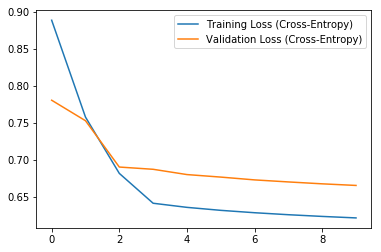

In [28]:
plt.plot(losses['train'], label='Training Loss (Cross-Entropy)')
plt.plot(losses['validation'], label='Validation Loss (Cross-Entropy)')
plt.legend();

# Hyperparameter optimization

In [29]:
from skopt.space import Real, Integer, Categorical
from IPython.display import clear_output, display

n_calls, n_called = 2000, 0

param_order = [
    'learning_rate',
    'weight_decay',
    'epochs',
    'layers',
    'dropouts',
    'embedding_dropout',
    'use_batch_norm'
]

dimensions = [
    Real(1e-8, 1, name='learning_rate'),
    Real(1e-5, 1e-1, name='weight_decay'),
    Integer(5, 2500, name='epochs'),
    Categorical([(60, 60), (60, 30, 15, 10, 5), (60, 30), (60, 30, 15), (30, 15)], name='layers'),
    Real(0., 0.75, name='dropouts'),
    Real(0., 0.75, name='embedding_dropout'),
    Categorical([True, False], name='use_batch_norm')
]

@skopt.utils.use_named_args(dimensions=dimensions)
def objective(learning_rate=1e-4, weight_decay=0.04, epochs=10, layers=[10, 10], dropouts=[0.2, 0.2], 
              embedding_dropout=0.2, use_batch_norm=True):
    
    # Reset as much as possible
    torch.cuda.empty_cache()
    seed_everything(random_seed)

    layers = list(layers)
    
    # Build model
    emb_model = EimModel(emb_szs, len(conts), embedding_dropout, 1, layers, dropouts, y_range=y_range, 
                         classify=True, use_bn=use_batch_norm)
    emb_model.to(device)
    
    opt = SGD(emb_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    crit = F.binary_cross_entropy
    losses = eim_train(emb_model, model_data, opt, crit, epochs, patience=25, print_output=False, save_best=False)
    
    return(min(losses['validation']))

In [30]:
class ProgressCallback():
    def __init__(self):
        pass

    def __call__(self, res):
        calls = len(res['func_vals'])
        clear_output()
        print('\rCompleted trial {}/{}'.format(calls, n_calls))

In [31]:
class CheckpointSaver(object):
    def __init__(self, checkpoint_path, **dump_options):
        self.checkpoint_path = checkpoint_path
        self.dump_options = dump_options

    def __call__(self, res):
        from skopt import dump
        dump(res, self.checkpoint_path, **self.dump_options)

In [32]:
checkpoint_callback = CheckpointSaver(Path('.', 'opt_checkpoint.pkl'))
progress_callback = ProgressCallback()

opt_checkpoint_path = Path('.', 'opt_checkpoint.pkl')

In [54]:
import pathlib

resume_optimization = True
previous_x0, previous_y0 = None, None

if resume_optimization:
    from skopt import load
    
    if opt_checkpoint_path.exists:
        previous_res = load(opt_checkpoint_path)
        previous_x0 = previous_res.x_iters
        previous_y0 = previous_res.func_vals
        n_called = len(previous_x0)

In [55]:
n_called

148

In [56]:
n_calls - n_called

1852

In [ ]:
opt_results = skopt.gp_minimize(objective,
                                dimensions,
                                n_calls=n_calls - n_called,
                                random_state=random_seed,
                                x0=previous_x0,
                                y0=previous_y0,
                                callback=[progress_callback, checkpoint_callback])

Completed trial 150/2000


# Train tuned model

## Get best parameters

In [36]:
from skopt import load
opt_results = load(opt_checkpoint_path)

In [37]:
print('Best loss: {}'.format(opt_results.fun))

Best loss: 0.5955487489700317


In [38]:
print('Parameters:')
opt_params = dict(zip(param_order, opt_results.x))
opt_params

Parameters:


{'learning_rate': 0.5409990228324164,
 'weight_decay': 1e-05,
 'epochs': 2500,
 'layers': (60, 30, 15),
 'dropouts': 0.6276112488574774,
 'embedding_dropout': 0.0,
 'use_batch_norm': True}

Train model with these parameters until we start to diverge

In [39]:
seed_everything(random_seed)
epochs = 5000
emb_model = EimModel(emb_szs, len(conts), opt_params['embedding_dropout'], 1, list(opt_params['layers']), 
                     opt_params['dropouts'], y_range=y_range, classify=True, 
                     use_bn=opt_params['use_batch_norm'])
emb_model.to(device)
opt = SGD(emb_model.parameters(), lr=opt_params['learning_rate'], weight_decay=opt_params['weight_decay'])
losses = eim_train(emb_model, model_data, opt, crit, epochs, save_best=True)

Epoch: 1/5000, Train Loss: 0.8946560621261597, Validation Loss: 0.6876766681671143
Epoch: 2/5000, Train Loss: 0.6857378482818604, Validation Loss: 0.6387289762496948
Epoch: 3/5000, Train Loss: 0.6321710348129272, Validation Loss: 0.6254568696022034
Epoch: 4/5000, Train Loss: 0.6169031262397766, Validation Loss: 0.6206015348434448
Epoch: 5/5000, Train Loss: 0.6107935905456543, Validation Loss: 0.6189981698989868
Epoch: 6/5000, Train Loss: 0.6083681583404541, Validation Loss: 0.6185595989227295
Epoch: 7/5000, Train Loss: 0.6073877215385437, Validation Loss: 0.6183799505233765
Epoch: 8/5000, Train Loss: 0.6068851947784424, Validation Loss: 0.6182711720466614
Epoch: 9/5000, Train Loss: 0.60654616355896, Validation Loss: 0.6181579828262329
Epoch: 10/5000, Train Loss: 0.6062456369400024, Validation Loss: 0.6179386377334595
Epoch: 11/5000, Train Loss: 0.6059613227844238, Validation Loss: 0.617594838142395
Epoch: 12/5000, Train Loss: 0.6056894063949585, Validation Loss: 0.6172212958335876
Epoc

## Plot training results

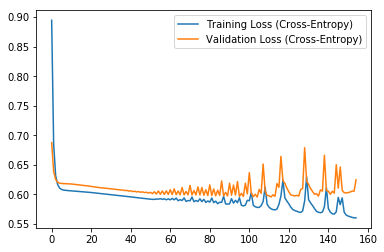

In [40]:
plt.plot(losses['train'], label='Training Loss (Cross-Entropy)')
plt.plot(losses['validation'], label='Validation Loss (Cross-Entropy)')
plt.legend();

## Load best model

In [41]:
emb_model = EimModel(emb_szs, len(conts), opt_params['embedding_dropout'], 1, list(opt_params['layers']), 
                     opt_params['dropouts'], y_range=y_range, classify=True, 
                     use_bn=opt_params['use_batch_norm'])
emb_model.to(device)
emb_model.load_state_dict(torch.load(Path('.', 'best_model.pkl')))

## Evaluate validation set against model

In [42]:
data = next(iter(model_data.val_dl))

emb_model.eval()

# get inputs
x_cats, x_conts, y = data

# wrap with variable
x_cats = torch.LongTensor(x_cats).to(device)
x_conts = torch.FloatTensor(x_conts).to(device)
y = torch.FloatTensor(y).to(device)
x_cats.requires_grad = False
x_conts.requires_grad = False
y.requires_grad = False

val_outputs = emb_model(x_cats, x_conts).cpu().detach().numpy()
val_y = y.cpu().detach().numpy()

### Plot validation AUC-PR

Average precision-recall score: 0.44


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.44')

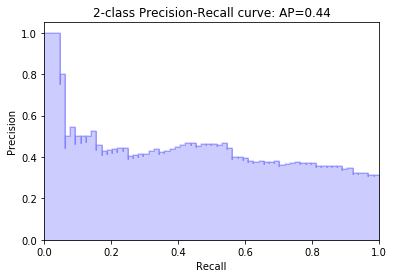

In [43]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(val_y, val_outputs)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, thresholds = precision_recall_curve(val_y, val_outputs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### Determine threshold for optimum F-beta / Calculate F-beta score for validation set

In [44]:
def threshold_array(threshold, array):
    array = array.copy()
    array[array >= threshold] = 1.
    array[array < threshold] = 0.
    return array

In [45]:
from sklearn.metrics import confusion_matrix, fbeta_score

In [46]:
best_fbeta = 0.0
best_fbeta_thresh = 0.0
for thresh in thresholds:
    val_outputs_thresh = threshold_array(thresh, val_outputs)
    fb = fbeta_score(val_y, val_outputs_thresh, 0.5, average='weighted')
    if fb >= best_fbeta:
        best_fbeta = fb
        best_fbeta_thresh = thresh

print('Best F_0.5 {} (at threshold {})'.format(best_fbeta, best_fbeta_thresh))

Best F_0.5 0.680473372781065 (at threshold 0.35040584206581116)


## Evaluate test set against model

In [47]:
test_outputs = None
for data in iter(model_data.test_dl):

    emb_model.eval()

    # get inputs
    x_cats, x_conts, y = data

    # wrap with variable
    x_cats = torch.LongTensor(x_cats).to(device)
    x_conts = torch.FloatTensor(x_conts).to(device)
    x_cats.requires_grad = False
    x_conts.requires_grad = False

    outputs = emb_model(x_cats, x_conts).cpu().detach().numpy()
    if test_outputs is not None:
        test_outputs = np.concatenate((test_outputs, outputs))
    else:
        test_outputs = outputs

### Plot test AUC-PR

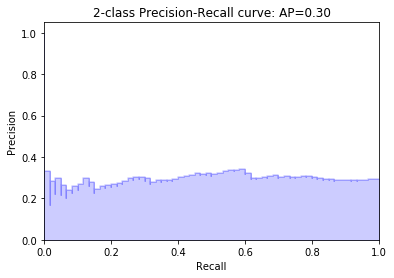

In [48]:
average_precision = average_precision_score(test_y, test_outputs)

# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))

precision, recall, thresholds = precision_recall_curve(test_y, test_outputs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

### Determine threshold for optimum F-beta / Calculate F-beta score for test set

In [49]:
best_fbeta = 0.0
best_fbeta_thresh = 0.0
for thresh in thresholds:
    test_outputs_thresh = threshold_array(thresh, test_outputs)
    fb = fbeta_score(test_y, test_outputs_thresh, 0.5, average='weighted')
    if fb >= best_fbeta:
        best_fbeta = fb
        best_fbeta_thresh = thresh

print('Best F_0.5 {} (at threshold {})'.format(best_fbeta, best_fbeta_thresh))

Best F_0.5 0.6123766778168269 (at threshold 0.302116721868515)


## Collect CV results from multiple runs against validation and test sets

## Test results against baseline classifier

In [50]:
from sklearn.metrics import precision_recall_curve

class CustomEstimator():
    def __init__(self, cats, conts, emb_szs, embedding_dropout, layers, dropouts, y_range, use_batch_norm, lr, wd, epochs):
        self.cats = cats
        self.conts = conts
        self.emb_szs = emb_szs
        self.embedding_dropout = embedding_dropout
        self.layers = list(layers)
        self.dropouts = dropouts
        self.y_range = y_range
        self.use_batch_norm = use_batch_norm
        self.lr = lr
        self.wd = wd
        
    def fit(self, train_input, valid_input, train_y, valid_y):
        self.model = EimModel(self.emb_szs, len(self.conts), self.embedding_dropout, 1, self.layers, 
                              self.dropouts, y_range=self.y_range, classify=True, use_bn=self.use_batch_norm)
        self.model.to(device)
        self.opt = SGD(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        self.crit = F.binary_cross_entropy                
        self.epochs = epochs
        self.model_data = EimModelData.from_data_frames('./tmp', train_input, valid_input, 
                                                train_y, valid_y, cats, conts, bs=len(train_input))
        self.model.train()
        self.losses = eim_train(self.model, self.model_data, self.opt, self.crit, self.epochs, print_output=False, save_best=True, save_path='tmp_model.pkl')
        self.model.load_state_dict(torch.load(Path('.', 'tmp_model.pkl')))
    
    def score(self):
        self.model.eval()
        y, y_hat = self._get_test_outputs()
        precision, recall, thresholds = precision_recall_curve(y, y_hat)
        fbeta = self._get_best_fbeta(precision, recall, thresholds, y, y_hat)
        
        return fbeta
        
    
    def _get_test_outputs(self):
        self.model.eval()
        val_outputs = None
        ys = None
        for data in iter(self.model_data.val_dl):
            
            # get inputs
            x_cats, x_conts, y = data

            # wrap with variable
            x_cats = torch.LongTensor(x_cats).to(device)
            x_conts = torch.FloatTensor(x_conts).to(device)
            y = torch.FloatTensor(y).to(device)
            x_cats.requires_grad = False
            x_conts.requires_grad = False
            y.requires_grad = False

            outputs = self.model(x_cats, x_conts).cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            if val_outputs is not None:
                val_outputs = np.concatenate((val_outputs, outputs))
                ys = np.concatenate((ys, y))
            else:
                val_outputs = outputs
                ys = y
        return (ys, val_outputs)
    
    def _get_best_fbeta(self, precision, recall, thresholds, y, y_hat):
        best_fbeta = 0.0
        best_fbeta_thresh = 0.0
        for thresh in thresholds:
            y_hat_thresh = threshold_array(thresh, y_hat)
            fb = fbeta_score(y, y_hat_thresh, 0.5, average='weighted')
            if fb >= best_fbeta:
                best_fbeta = fb
                best_fbeta_thresh = thresh
        return best_fbeta

custom_estimator = CustomEstimator(cats, conts, emb_szs, opt_params['embedding_dropout'], 
                                   opt_params['layers'], opt_params['dropouts'], y_range, 
                                   opt_params['use_batch_norm'], opt_params['learning_rate'], 
                                   opt_params['weight_decay'], opt_params['epochs'])

In [51]:
class BaselineEstimator():
    def __init__(self):
        pass
    
    def fit(self, train_input, valid_input, train_y, valid_y):
        self.valid_y = np.array(valid_y)
    
    def score(self):
        y = self.valid_y
        y_hat = np.zeros(y.shape)
        
        precision, recall, thresholds = precision_recall_curve(y, y_hat)
        fbeta = self._get_best_fbeta(precision, recall, [0.5], y, y_hat)
        
        return fbeta        
    
    def _get_best_fbeta(self, precision, recall, thresholds, y, y_hat):
        best_fbeta = 0.0
        best_fbeta_thresh = 0.0
        for thresh in thresholds:
            y_hat_thresh = threshold_array(thresh, y_hat)
            fb = fbeta_score(y, y_hat_thresh, 0.5, average='weighted')
            if fb >= best_fbeta:
                best_fbeta = fb
                best_fbeta_thresh = thresh
        return best_fbeta
    
baseline_estimator = BaselineEstimator()

In [52]:
def paired_ttest_5x2cv(estimator1, estimator2, X_train, 
                       X_valid,
                       y_train,
                       y_valid):
    """
    Adapted from http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
    """
    
    from scipy import stats
    
    variance_sum = 0.
    first_diff = None

    def score_diff(X_1, X_2, y_1, y_2):

        estimator1.fit(X_1, X_2, y_1, y_2)
        estimator2.fit(X_1, X_2, y_1, y_2)
        est1_score = estimator1.score()
        est2_score = estimator2.score()
        score_diff = est1_score - est2_score
        return {
            'custom': est1_score,
            'baseline': est2_score,
            'score_diff': score_diff
        }
    
    scores = {
        'custom': [],
        'baseline': []
    }

    for i in range(5):
        
        train_idxs = np.random.choice(np.array(y_train.index), len(y_train.index)//2)
        valid_idxs = np.random.choice(np.array(y_valid.index), len(y_valid.index)//2)
        
        X_1, X_2  = X_train.iloc[train_idxs], X_valid.iloc[valid_idxs]
        y_1, y_2  = y_train.iloc[train_idxs], y_valid.iloc[valid_idxs]

        print('Iteration {}'.format(i+1))

        score_diff_1 = score_diff(X_1, X_2, y_1, y_2)
        score_diff_2 = score_diff(X_2, X_1, y_2, y_1)
        score_mean = (score_diff_1['score_diff'] + score_diff_2['score_diff']) / 2.
        score_var = ((score_diff_1['score_diff'] - score_mean)**2 +
                     (score_diff_2['score_diff'] - score_mean)**2)
        variance_sum += score_var
        if first_diff is None:
            first_diff = score_diff_1['score_diff']
        
        scores['custom'].append(score_diff_1['custom'])
        scores['custom'].append(score_diff_2['custom'])
        scores['baseline'].append(score_diff_1['baseline'])
        scores['baseline'].append(score_diff_2['baseline'])

    scores['means'] = {
       'custom': np.mean(scores['custom']),
       'baseline': np.mean(scores['baseline'])
    }
    
    numerator = first_diff
    denominator = np.sqrt(1/5. * variance_sum)
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), 5)*2.
    return {
        't_stat': float(t_stat),
        'pvalue': float(pvalue),
        'scores': scores
    }

In [53]:
paired_ttest_5x2cv(custom_estimator, 
                   baseline_estimator, 
                   pd.concat([train_input, valid_input], ignore_index=True), 
                   test_input, 
                   pd.concat([train_y, valid_y], ignore_index=True), 
                   valid_y)

Iteration 1
Early stopping


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Early stopping
Iteration 2
Early stopping
Early stopping
Iteration 3
Early stopping
Early stopping
Iteration 4
Early stopping
Early stopping
Iteration 5
Early stopping
Early stopping


{'t_stat': 2.6648521975552217,
 'pvalue': 0.044623241242343896,
 'scores': {'custom': [0.5966987301637414,
   0.6083828493537157,
   0.597775147095474,
   0.6050862824392079,
   0.7366071428571429,
   0.5993825968546549,
   0.6872272950480998,
   0.6032319953018437,
   0.6705500189803656,
   0.6213827328466185],
  'baseline': [0.44682672400063705,
   0.527611650866144,
   0.48472617917062366,
   0.5346884666372073,
   0.510718789407314,
   0.5135777377293785,
   0.5507794140686199,
   0.5066209004326236,
   0.48472617917062366,
   0.4974077571528297],
  'means': {'custom': 0.6326324790940865, 'baseline': 0.5057683798636001}}}